# Library calls

In [1]:
import pandas as pd 
import numpy as np  
import seaborn as sns 
import matplotlib.pyplot as  plt 
import cv2
import tensorflow as tf 
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,Flatten,InputLayer,Input
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications import ResNet152V2,DenseNet121,InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy,TruePositives,TrueNegatives,FalseNegatives,FalsePositives
from tensorflow.keras.regularizers import L2
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score

# Load the dataset

In [2]:
directory = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'

In [3]:
class_names = ['no','yes']

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=None,
    image_size=(256, 256),
    shuffle=True,
    seed=42
)

Found 253 files belonging to 2 classes.


# Data preprocessing 

## splits

In [5]:
def splits(dataset,Train_ratio,Val_ratio,Test_ratio):
    
    data_size = len(dataset)
    
    train_dataset = dataset.take(int(data_size*Train_ratio))
    
    val_split_set = dataset.skip(int(data_size*Train_ratio))
    
    val_dataset = val_split_set.take((int(data_size*Val_ratio)))
    
    test_dataset = val_split_set.skip(int(data_size*Test_ratio))
    return train_dataset,val_dataset,test_dataset 

Train_ratio = 0.80 
Val_ratio = .10
Test_ratio = 0.10
train_dataset,val_dataset,test_dataset  = splits(dataset,Train_ratio,Val_ratio,Test_ratio)

print("The length of the train_dataset is  : ",len(train_dataset))
print('The length of the val_dataset is  : ',len(val_dataset))
print('The length of the test_dataset is  : ',len(test_dataset))
      

The length of the train_dataset is  :  202
The length of the val_dataset is  :  25
The length of the test_dataset is  :  26


## visualize some image

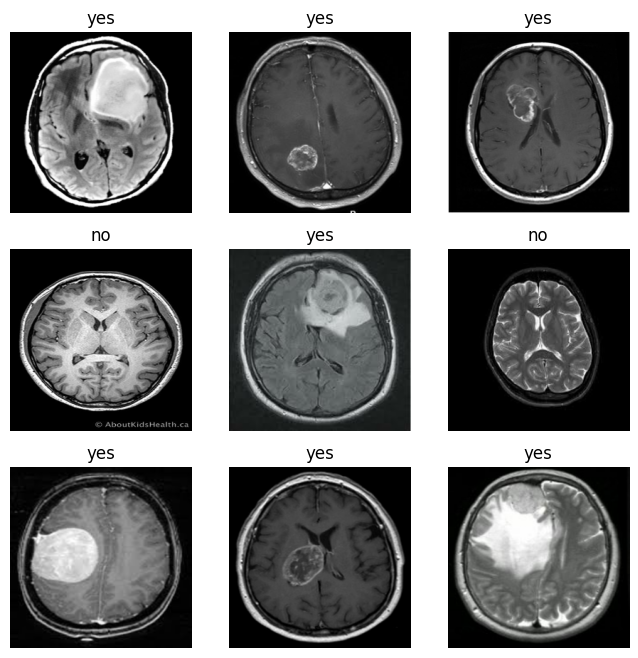

In [6]:
plt.figure(figsize=(8,8))
for i,(image,label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image/255)
    plt.title(class_names[label])
    plt.axis('off')

## Dataset prepraration

In [7]:
#  resize and rescaling

def resize_rescaling(image,label):
    
    return tf.image.resize(image,(224,224))/255,label

In [8]:
train_dataset = (
             train_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(10)
            .prefetch(tf.data.AUTOTUNE)
)

In [9]:
val_dataset = (
             val_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(3)
            .prefetch(tf.data.AUTOTUNE)
)

In [10]:
test_dataset = (
             test_dataset
            .shuffle(reshuffle_each_iteration=True,buffer_size=8)
            .map(resize_rescaling)
            .batch(1)
            .prefetch(tf.data.AUTOTUNE)
)

# Create  a model 

In [11]:
Lenet_model = tf.keras.Sequential([
    InputLayer(shape=(224,224,3)),
    
    Conv2D(filters=32, kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(pool_size=3,strides=2),

    Conv2D(filters=32,kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
    
    BatchNormalization(),
    MaxPooling2D(pool_size=3,strides=1),
    
    Conv2D(filters=32,kernel_size=3,strides=2,padding='valid',activation='relu',kernel_regularizer=L2(0.01)),
    
    BatchNormalization(),

    MaxPooling2D(pool_size=3,strides=1),
    Dropout(0.2),
    

    Flatten(),
    
    Dense(64,activation='relu'),
    BatchNormalization(),
    
    Dense(64,activation='relu'),
    BatchNormalization(),
    
    Dense(1,activation='sigmoid')
],name='Lenet_model')
Lenet_model.summary()

Model: "Lenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,377 (896.00 KB)

 Trainable params: 228,929 (894.25 KB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
Lenet_model.compile(loss = BinaryCrossentropy(),
                   optimizer=Adam(learning_rate=0.001),
                   metrics = ['accuracy'])

In [13]:
checkpoint_path = "/kaggle/working/best_model.keras"  # Change the extension to .h5
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,  # Corrected parameter name and file extension
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30, 
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

In [14]:
history = Lenet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=30,
                          verbose=1,
                          callbacks = [checkpoint_callback,
                                      early_stopping ]
                       
                         )

Epoch 1/30


I0000 00:00:1740047751.294077     104 service.cc:145] XLA service 0x7a8ec8007a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740047751.294148     104 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6315 - loss: 1.3016

I0000 00:00:1740047756.953488     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6407 - loss: 1.3037

I0000 00:00:1740047761.447466     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 172 bytes spill stores, 212 bytes spill loads




Epoch 1: val_loss improved from inf to 1.38308, saving model to /kaggle/working/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 300ms/step - accuracy: 0.6415 - loss: 1.3046 - val_accuracy: 0.4800 - val_loss: 1.3831
Epoch 2/30
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7895 - loss: 1.1628
Epoch 2: val_loss improved from 1.38308 to 1.28718, saving model to /kaggle/working/best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7866 - loss: 1.1634 - val_accuracy: 0.8000 - val_loss: 1.2872
Epoch 3/30
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8038 - loss: 1.1221
Epoch 3: val_loss did not improve from 1.28718
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8012 - loss: 1.1224 - val_accuracy: 0.6000 - val_loss: 1.3205
Epoch 4/30
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7908 - loss: 1.0640
Epoch 4: val_loss did not improve from 1.28718
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8016 - loss: 1.0569 - val_accuracy: 0.5600 - val

## Evaluate the model 

In [15]:
def evaluate_model(model,dataset):
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    accuracy = model.history.history['accuracy']
    val_accuracy = model.history.history['val_accuracy']
    
    plt.figure(figsize=(14,12))
    
    # Plot model loss 
    plt.subplot(2,2,1)
  
    plt.plot(val_loss)
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel('Loss')
    plt.legend(['train_loss','val_loss'])
    plt.grid()

    # Plot model accuracy
    plt.subplot(2,2,2)
   
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel('Accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.grid()
    
    # confusion matrix
    plt.subplot(2,2,3)
    
    img = []
    labels = []
    for x,y in dataset:
        img.append(x)
        labels.append(y)
    true_label = np.array(labels).flatten()
    predicted = model.predict(np.array(img)[:,0,...])[:,0]
    
    threshold = 0.5

    cm = confusion_matrix(true_label, predicted > threshold)
   
  

    sns.heatmap(cm, annot=True,cmap='Blues',xticklabels=['NO','YES'],yticklabels=['NO','YES'])
    plt.title('Confusion matrix - {}'.format(threshold))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    # Plot roc curve
    plt.subplot(2,2,4)

    fp, tp, thresholds = roc_curve(true_label, predicted)
    roc_auc = roc_auc_score(true_label,predicted)
    plt.plot(fp,tp, color='blue',  label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],linestyle='--')
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")

    plt.grid()

    skip = 2

    for i in range(0, len(thresholds), skip):
      plt.text(fp[i], tp[i], thresholds[i])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


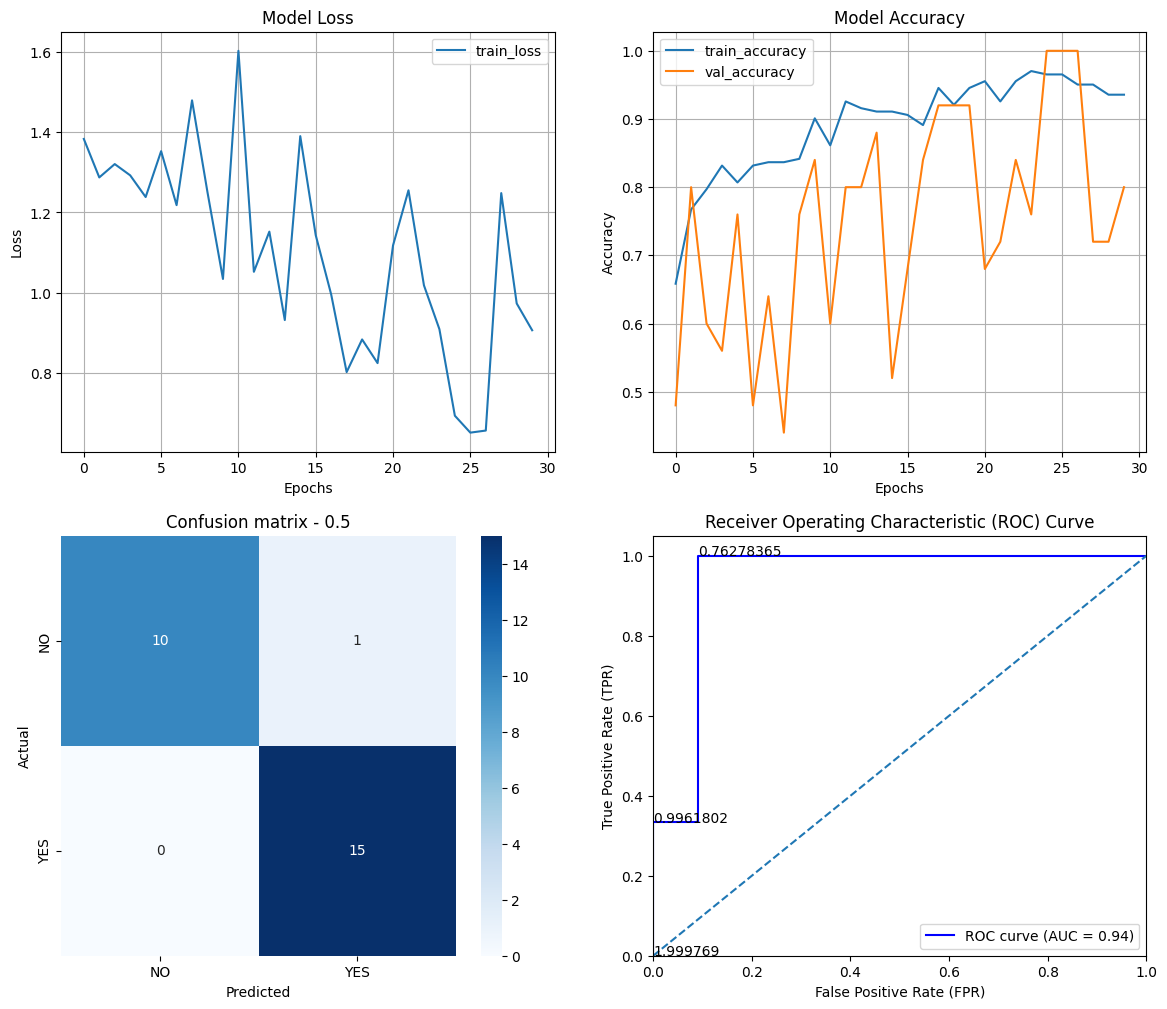

In [16]:
evaluate_model(Lenet_model,test_dataset)

In [17]:
test_evaluate = Lenet_model.evaluate(test_dataset)
test_evaluate

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.6241  


[0.6596737504005432, 1.0]

In [18]:
val_evaluate = Lenet_model.evaluate(val_dataset)
val_evaluate

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9347 - loss: 0.8125  


[0.7555315494537354, 0.9599999785423279]

# Transform Learning 

## ResNet152V2

In [19]:
resnet_backbone = ResNet152V2(
    include_top=False,
    weights='imagenet',
    input_shape= (224,224,3)
)
inputs = Input(shape=(224,224,3))
x = resnet_backbone(inputs)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1,activation='sigmoid')(x)
Resnet_model = Model(inputs,outputs,name='Resnet_model')
Resnet_model.compile(loss = BinaryCrossentropy(),
                   optimizer=Adam(learning_rate=0.0001),
                   metrics = ['accuracy'])
Resnet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=25,
                          verbose=1
                       
                         )

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25


I0000 00:00:1740047950.854772     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_38', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_21', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_46', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_43', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_41', 4 bytes spill stores, 12 bytes spill loads



20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6416 - loss: 0.6982

I0000 00:00:1740048044.633421     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_62', 432 bytes spill stores, 468 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_41', 4 bytes spill stores, 12 bytes spill loads



21/21 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.6490 - loss: 0.6894 - val_accuracy: 0.4800 - val_loss: 3.3051
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.8320 - loss: 0.3806 - val_accuracy: 0.4400 - val_loss: 1.7398
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.8594 - loss: 0.3649 - val_accuracy: 0.6400 - val_loss: 0.8551
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.9180 - loss: 0.2128 - val_accuracy: 0.8800 - val_loss: 0.3125
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9469 - loss: 0.1423 - val_accuracy: 0.9200 - val_loss: 0.1503
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9545 - loss: 0.1411 - val_accuracy: 0.8800 - val_loss: 0.2274
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9657 - loss: 0.1097 - val_accuracy: 0.8800 - val_loss: 0.3162
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.9701 - loss: 0.1298 - val_accuracy: 0.8400 - val_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


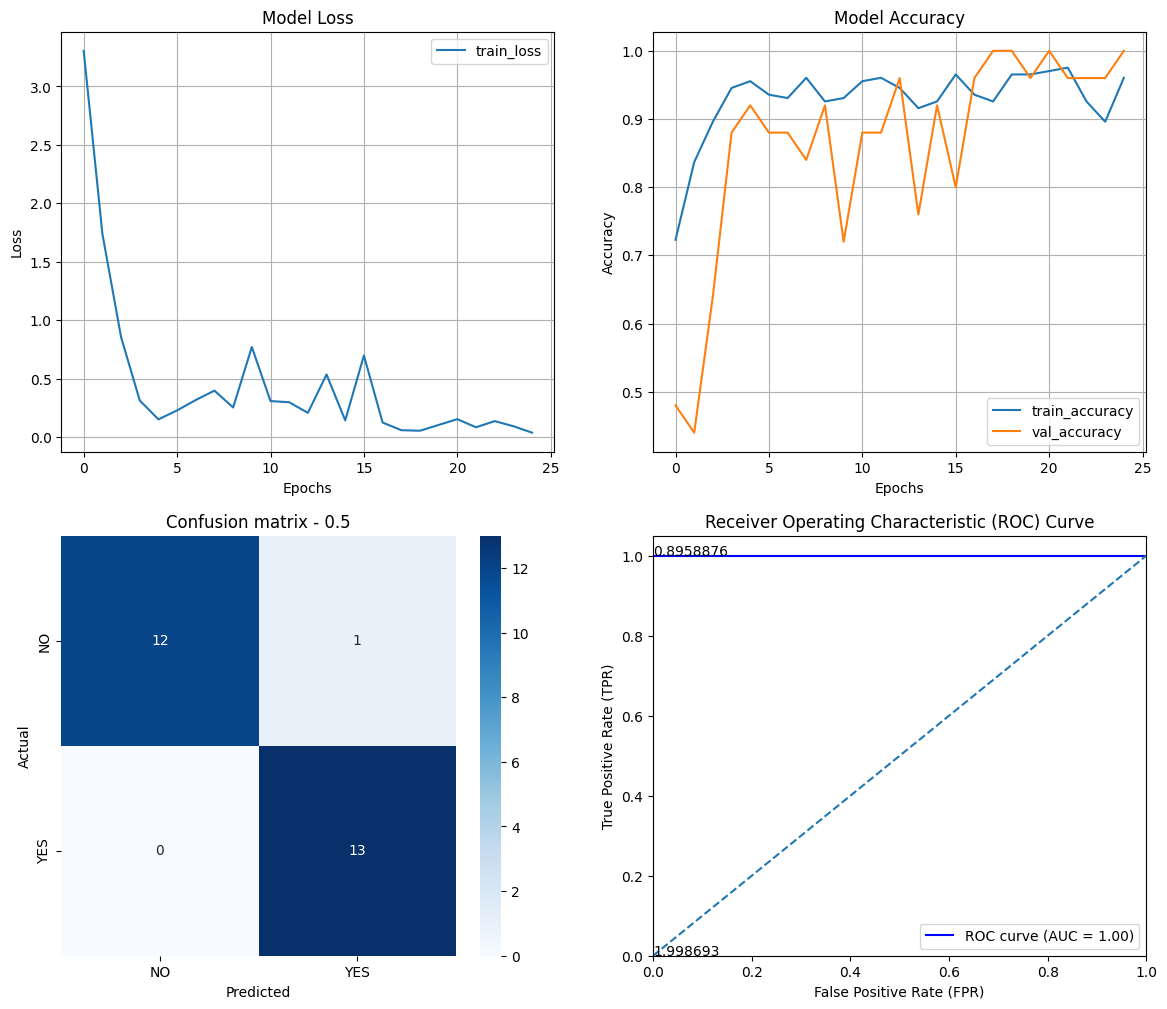

In [20]:
evaluate_model(Resnet_model,test_dataset)

## DenseNet121

In [21]:
DenseNet_backbone = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape= (224,224,3)
)
inputs = Input(shape=(224,224,3))
x = DenseNet_backbone(inputs)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1,activation='sigmoid')(x)
Densenet_model = Model(inputs,outputs,name='Resnet_model')
Densenet_model.compile(loss = BinaryCrossentropy(),
                   optimizer=Adam(learning_rate=0.0001),
                   metrics = ['accuracy'])
Densenet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=25,
                          verbose=1
                       
                         )

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6594 - loss: 0.6971

I0000 00:00:1740048390.064646     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 156 bytes spill stores, 184 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_38', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_20', 20 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_21', 48 bytes spill stores, 48 bytes spill loads



21/21 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.6642 - loss: 0.6907 - val_accuracy: 0.8800 - val_loss: 0.4337
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8711 - loss: 0.2758 - val_accuracy: 0.7200 - val_loss: 0.7162
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9515 - loss: 0.1798 - val_accuracy: 0.6400 - val_loss: 0.8364
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9637 - loss: 0.1411 - val_accuracy: 0.8800 - val_loss: 0.2468
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9460 - loss: 0.1644 - val_accuracy: 0.9200 - val_loss: 0.3197
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9536 - loss: 0.1340 - val_accuracy: 0.8800 - val_loss: 0.2504
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9806 - loss: 0.1065 - val_accuracy: 0.6800 - val_loss: 0.7053
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9699 - loss: 0.0878 - val_accuracy: 0.7600 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


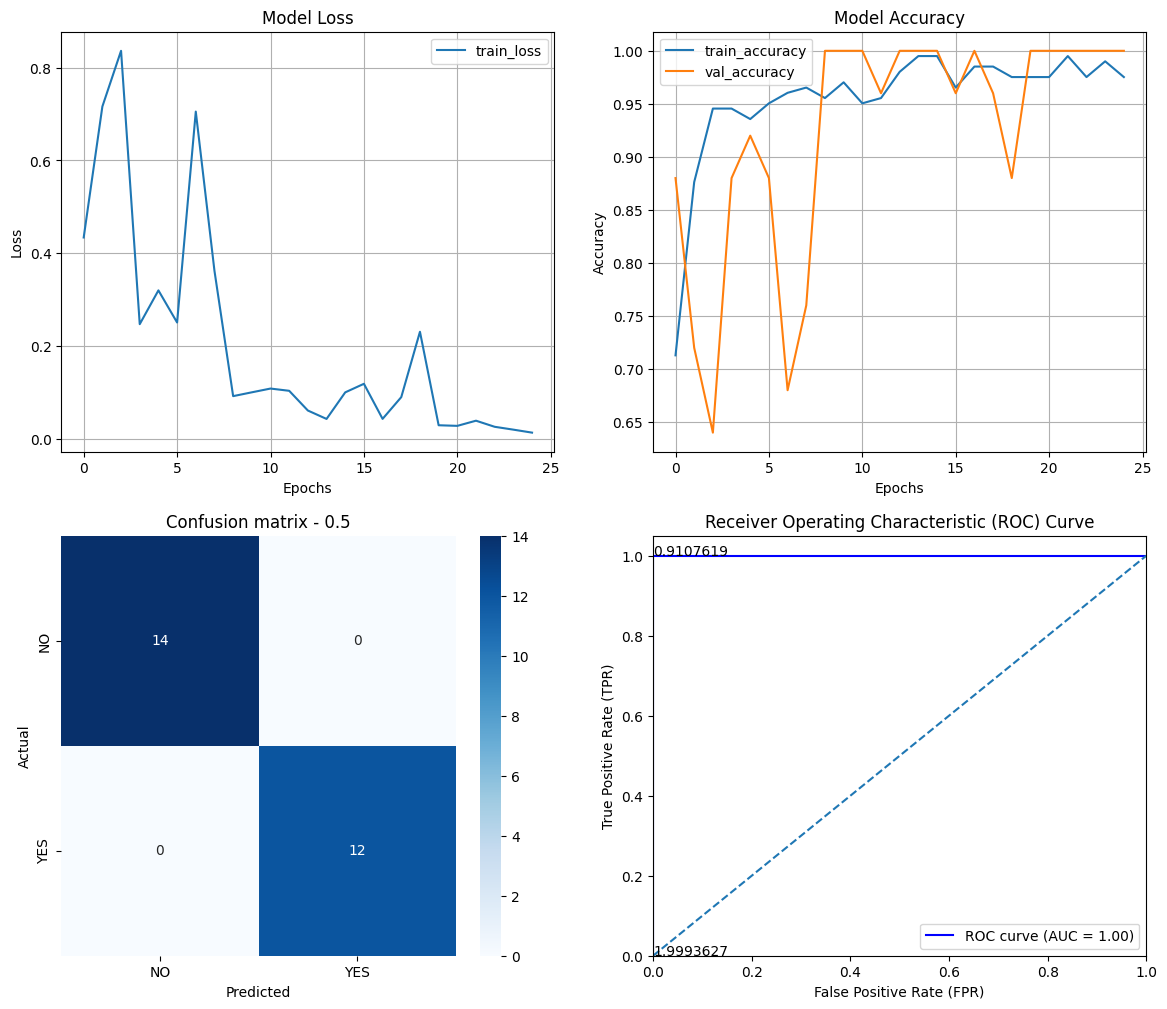

In [22]:
evaluate_model(Densenet_model,test_dataset)

## InceptionResNetV2

In [23]:
InceptResnet_backbone = InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape= (224,224,3)
)
inputs = Input(shape=(224,224,3))
x = InceptResnet_backbone (inputs)
x = Flatten()(x)
x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64,activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1,activation='sigmoid')(x)
InceptResnet_model = Model(inputs,outputs,name='Resnet_model')
InceptResnet_model.compile(loss = BinaryCrossentropy(),
                   optimizer=Adam(learning_rate=0.0001),
                   metrics = ['accuracy'])
InceptResnet_model.fit(train_dataset,
                          validation_data=val_dataset,
                          epochs=25,
                          verbose=1
                       
                         )

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/25


I0000 00:00:1740048665.278964     102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_58', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_154', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_153', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 byte

20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.5934 - loss: 0.8042

I0000 00:00:1740048732.138897     104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 160 bytes spill stores, 160 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 100 bytes spill stores, 100 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_216', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_192', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_191', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_110', 104 bytes spill stores, 132 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_no

21/21 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.6051 - loss: 0.7863 - val_accuracy: 0.5200 - val_loss: 0.9414
Epoch 2/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.8605 - loss: 0.3166 - val_accuracy: 0.9600 - val_loss: 0.2898
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.8761 - loss: 0.3042 - val_accuracy: 0.8000 - val_loss: 0.5629
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.9486 - loss: 0.1300 - val_accuracy: 0.8800 - val_loss: 0.4574
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.9362 - loss: 0.1857 - val_accuracy: 0.8400 - val_loss: 0.3095
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.9931 - loss: 0.0753 - val_accuracy: 0.8800 - val_loss: 0.2800
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.9695 - loss: 0.1096 - val_accuracy: 1.0000 - val_loss: 0.1226
Epoch 8/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.9889 - loss: 0.1014 - val_accuracy: 0.8000 - val_l

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


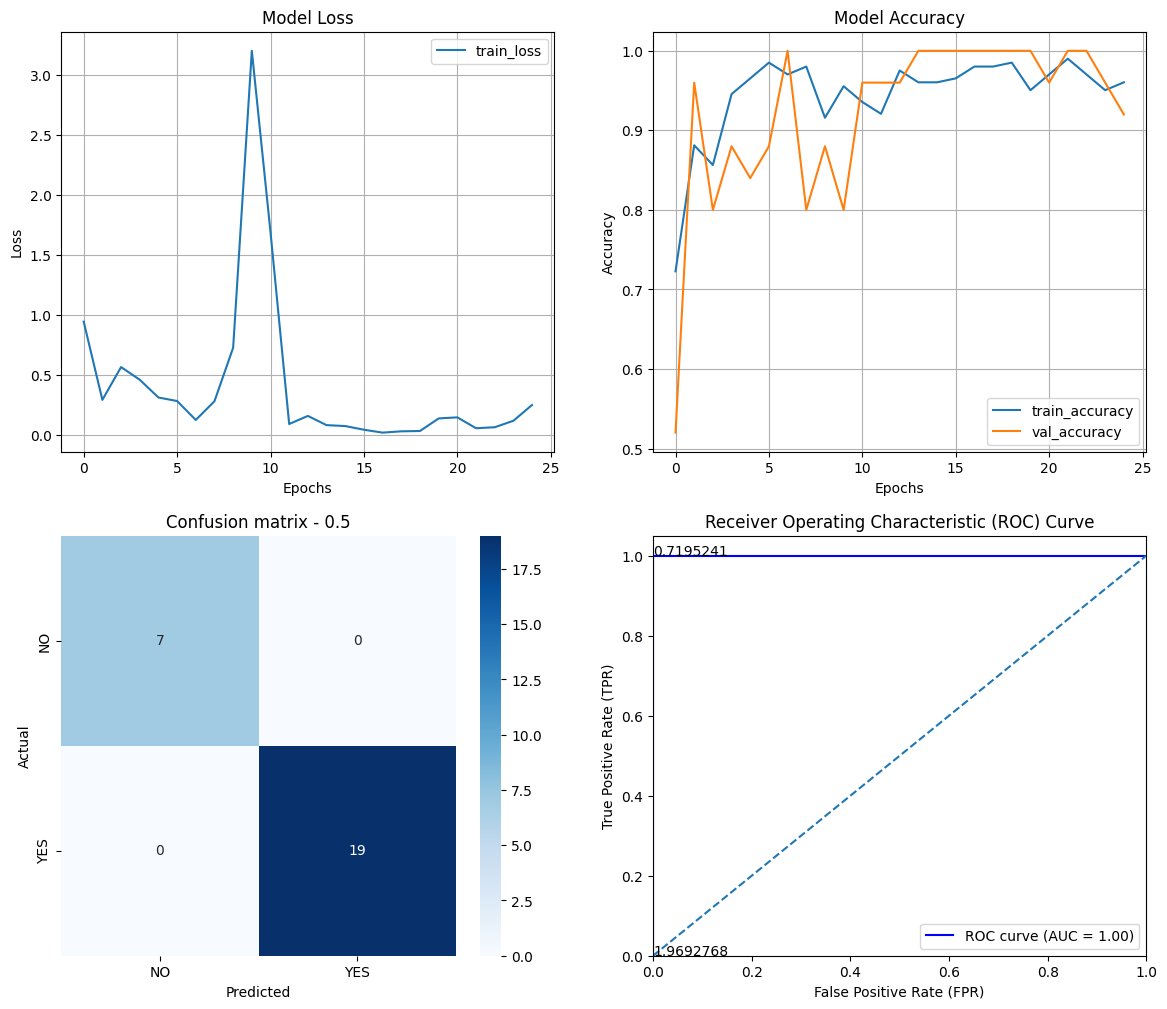

In [24]:
evaluate_model(InceptResnet_model,test_dataset)

# Test the a model 

## single prediction

In [25]:
def Tumor_or_Not(x):
    if x<.5:
        return str('no')
    else:
        return str('yes')

In [26]:
image = cv2.resize(cv2.imread('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y101.jpg'),(224,224))
im   = tf.expand_dims(image,axis=0)
pred = Lenet_model.predict(im)[0][0]
print(Tumor_or_Not(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
yes


## multiple prediction with visualize

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


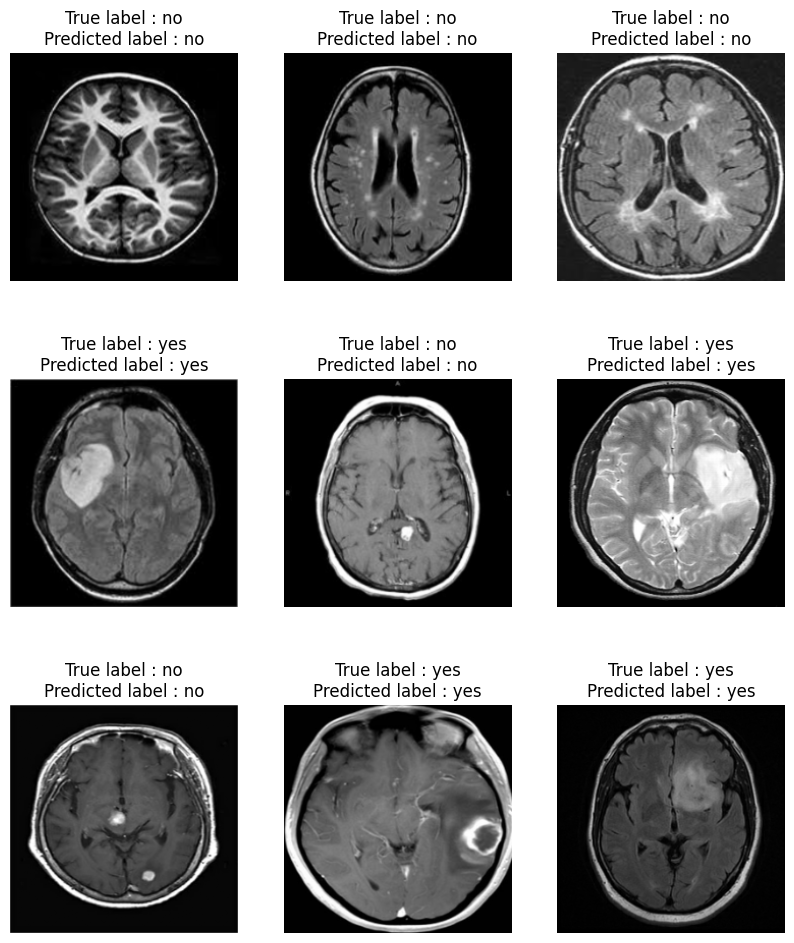

In [27]:
plt.figure(figsize=(10,12))
for i,(image,label) in  enumerate(test_dataset.take(9)):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image[0])
    plt.title('True label : '+class_names[label[0]]+"\n"+'Predicted label : '+
             Tumor_or_Not(Lenet_model.predict(tf.expand_dims(image[0],axis=0))[0][0]))
    plt.axis('off')

# Save and load the model 

In [28]:
Lenet_model.save('Lenet_model.h5')

In [29]:
load_lenet = tf.keras.models.load_model('Lenet_model.h5')

In [30]:
# test our svae model
image = cv2.resize(cv2.imread('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y101.jpg'),(224,224))
im   = tf.expand_dims(image,axis=0)
pred = load_lenet.predict(im)[0][0]
print(Tumor_or_Not(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
yes


In [31]:
!pip install -U tf2onnx onnx
!pip install onnxruntime

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 10.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 91.3 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.0 MB/s eta 0:00:00


# load the model 

In [32]:
!mkdir /kaggle/working/Models/

In [33]:
# save tf format  
Lenet_model.export('/kaggle/working/Models/', format='onnx')


Saved artifact at '/kaggle/working/Models/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134755275190720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134755275440896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134755275442304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134755275443712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134755275440720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134755275441072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134755275446176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134755275441600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134755275447584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134755275449168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1347552

In [34]:
!python -m tf2onnx.convert --saved-model /kaggle/working/Models/ --output Lenet_model.onnx --opset 13

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2025-02-20 10:54:44,560 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2025-02-20 10:54:44,781 - INFO - Signatures found in model: [serve,serving_default].
2025-02-20 10:54:44,781 - WARNING - '--signature_def' not specified, using first signature: serve
2025-02-20 10:54:44,782 - INFO - Output names: ['output_0']
2025-02-20 10:54:44,984 - INFO - Using tensorflow=2.16.1, onnx=1.17.0, tf2onnx=1.16.1/15c810
2025-02-20 10:54:44,984 - INFO - Using opset <onnx, 13>
2025-02-20 10:54:44,998 - INFO - Computed 0 values for constant folding
2025-02-20 10:54:45,030 - INFO - Optimizing ONNX model
2025-02-20 10:54:45,142 - INFO - After optimization: Add -3 (11->8), Cast -1 (1->0), Identity -2 (2->0), Transpose -10 (12->2)
2025-02-20 10:5

In [35]:
import onnxruntime as nxrun
import numpy as np
from skimage.transform import resize
from skimage import io
import cv2
from tensorflow.keras.preprocessing.image import load_img
img = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y100.JPG"

image = load_img(img,target_size =(224,224))
image = np.float32(image)
ximg = np.expand_dims(image,0)

sess = nxrun.InferenceSession("/kaggle/working/Lenet_model.onnx")


input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
result = sess.run([label_name], {input_name: ximg})
prob = result[0]
lab = np.argmax(prob,-1)
class_names[lab[0]]

'no'